# model the data we gathered before

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from tqdm import tqdm
import cvxpy as cp

from plotters import *

In [3]:
class RollingPortfolio:
    """
    A sliding‐window MPT backtest that uses pre‐computed means & variances,
    and limits the backtest to exactly those end‐dates present in estimates_df.

    Args:
        prices       : pd.DataFrame of historical prices
                       (index = business dates, columns = tickers)
        estimates_df : pd.DataFrame with columns ['window','stock','Xmean','Variance']
                       - 'window' is a string “YYYY-MM-DD:YYYY-MM-DD”
                       - 'stock' is a ticker symbol
                       - 'Xmean' and 'Variance' are floats already computed
                         for each (window, stock)
        window_size  : int, length L of each rolling window
        lambda_risk  : float, risk‐aversion parameter (λ)
        kappa_turn   : float, turnover penalty (κ)
        w_max        : float, per‐asset maximum weight
        tau_max      : float, maximum allowable turnover (L₁) each day
    """

    def __init__(
        self,
        prices: pd.DataFrame,
        estimates_df: pd.DataFrame,
        window_size: int,
        lambda_risk: float,
        kappa_turn: float,
        w_max: float,
        tau_max: float,
    ):
        # ─────────────────────────────────────────────────────────────────────
        # 1) Store hyperparameters and raw data
        # ─────────────────────────────────────────────────────────────────────
        self.prices = prices.copy()
        self.window_size = window_size
        self.lambda_risk = lambda_risk
        self.kappa_turn = kappa_turn
        self.w_max = w_max
        self.tau_max = tau_max

        # Build returns DataFrame: simple pct_change, drop the first NaN row,
        self.returns = self.prices.pct_change()

        # Extract sorted list of all dates and asset tickers
        self.dates = self.returns.index
        self.assets = list(self.returns.columns)
        self.T = len(self.dates)
        self.N = len(self.assets)

        # ─────────────────────────────────────────────────────────────────────
        # 2) Pivot the pre‐computed estimates_df into two tables:
        #       mu_table[window_str, stock]  = Xmean
        #       var_table[window_str, stock] = Variance
        #    where window_str = “YYYY-MM-DD:YYYY-MM-DD”
        # ─────────────────────────────────────────────────────────────────────
        pivot_mu = estimates_df.pivot(index="window", columns="stock", values="Xmean")
        pivot_var = estimates_df.pivot(index="window", columns="stock", values="Variance")

        # Ensure every ticker in self.assets appears in the pivot columns
        missing_assets = set(self.assets) - set(pivot_mu.columns)
        if missing_assets:
            raise ValueError(
                f"Missing tickers in estimates_df pivot: {missing_assets}"
            )

        # Re‐index columns so that they match exactly self.assets (same order)
        pivot_mu = pivot_mu.reindex(columns=self.assets)
        pivot_var = pivot_var.reindex(columns=self.assets)

        self.mu_table = pivot_mu
        self.var_table = pivot_var

        # ─────────────────────────────────────────────────────────────────────
        # 3) Build a mapping from each “window_str” → its end_date (as Timestamp).
        #    Then keep only those end_dates that actually appear in self.returns.index.
        #
        #    We'll store:
        #      - self.window_map: a DataFrame with columns ["window_str","end_date"],
        #        filtered & sorted by end_date.
        #      - self.backtest_dates: a sorted list of T_end dates to iterate over.
        # ─────────────────────────────────────────────────────────────────────
        window_strs = list(self.mu_table.index)
        end_dates = []
        for w in window_strs:
            # Parse out everything after the “:” in the window string
            end = pd.to_datetime(w.split(":", 1)[1])
            end_dates.append(end)

        temp_map = pd.DataFrame({
            "window_str": window_strs,
            "end_date":   end_dates
        })

        # Keep only those rows where end_date is in the returns index
        temp_map = temp_map[temp_map["end_date"].isin(self.returns.index)].copy()

        # Sort by the end_date ascending
        temp_map = temp_map.sort_values("end_date").reset_index(drop=True)

        # final window_map and list of backtest dates
        self.window_map = temp_map
        self.backtest_dates = list(temp_map["end_date"].values)

        # ─────────────────────────────────────────────────────────────────────
        # 4) Prepare storage for weights & realized returns, 
        #    indexed by backtest_dates (not by all self.dates).
        # ─────────────────────────────────────────────────────────────────────
        self.weights_history = pd.DataFrame(
            index=self.backtest_dates,
            columns=self.assets,
            dtype=float
        )
        self.portf_returns = pd.Series(
            index=self.backtest_dates,
            dtype=float
        )


    def run_backtest(self) -> None:
        """
        Run a sliding-window MPT backtest using precomputed (Xmean, Variance).

        For each end_date in self.backtest_dates:
          a) Retrieve window_str from self.window_map
          b) Look up mu_vec, var_vec in mu_table/var_table
          c) Build Σ_t = diag(var_vec)
          d) Solve:
             max_{w ≥ 0, sum(w)=1, w ≤ w_max, ||w - w_prev||₁ ≤ τ_max}
                { wᵀ·mu_vec - λ·wᵀΣ_t w - κ·||w - w_prev||₁ }
          e) Compute realized return = (w_prev)ᵀ · (returns on end_date)
          f) Store w_t and realized return, then set w_prev ← w_t.
        """
        # Initialize w_prev at the first backtest date with equal weights
        # (this assumes N * w_max ≥ 1; otherwise choose a different feasible start)
        w_prev = np.ones(self.N) / self.N

        # Loop through each row of window_map, which is sorted by end_date
        for row in self.window_map.itertuples(index=False):
            window_str = row.window_str
            end_date = row.end_date  # a pandas Timestamp

            # 1) Look up precomputed means & variances for this window_str
            mu_series  = self.mu_table.loc[window_str]   # Series (index = self.assets)
            var_series = self.var_table.loc[window_str]  # Series (index = self.assets)

            mu_vec  = mu_series.values.reshape((self.N,))    # shape = (N,)
            var_vec = var_series.values.reshape((self.N,))   # shape = (N,)

            # 2) Build diagonal covariance Σ_t
            Sigma_t = np.diag(var_vec)

            # 3) Set up CVXPY variables & objective
            w = cp.Variable(self.N)

            #    Expected return: wᵀ · mu_vec
            exp_ret = mu_vec @ w

            #    Risk term: wᵀ Σ_t w   (assume PSD to skip extra symmetry checks)
            risk_term = cp.quad_form(w, Sigma_t, assume_PSD=True)

            #    Turnover: ||w - w_prev||₁
            turnover = cp.norm1(w - w_prev)

            #    Objective: maximize { exp_ret - λ·risk_term - κ·turnover }
            objective = cp.Maximize(
                exp_ret
                - self.lambda_risk * risk_term
                - self.kappa_turn * turnover
            )

            #    Constraints:
            constraints = [
                cp.sum(w) == 1,           # ∑ᵢ w_i = 1
                w >= 0,                   # w_i ≥ 0
                w <= self.w_max,          # w_i ≤ w_max
                turnover <= self.tau_max  # ∥w - w_prev∥₁ ≤ τ_max
            ]

            prob = cp.Problem(objective, constraints)

            # 4) Solve the QP+L1
            try:
                prob.solve(solver=cp.ECOS, warm_start=True)
            except:
                prob.solve(solver=cp.OSQP, warm_start=True)

            # 5) Retrieve the solution (or fallback if solver fails)
            if w.value is not None:
                w_opt = w.value
            else:
                print(f"Solver failed at {end_date}, reusing previous weights.")
                w_opt = w_prev.copy()

            # 6) Store w_opt in weights_history
            self.weights_history.loc[end_date] = w_opt

            # 7) Compute realized portfolio return on end_date using w_prev
            realized_r = w_prev @ self.returns.loc[end_date].values
            self.portf_returns.loc[end_date] = realized_r

            # 8) Update for next iteration
            w_prev = w_opt.copy()

        # End of loop – now weights_history and portf_returns are fully populated.


    def summary_statistics(self):
        """
        After run_backtest(), compute:
          - "cumulative_wealth": pd.Series (index = backtest_dates)
          - "annual_return"    : float
          - "annual_volatility": float
          - "annual_sharpe"    : float

        Note: we assume 252 business days per year.
        """
        cum_wealth = (1 + self.portf_returns).cumprod()

        daily_ret = self.portf_returns.dropna()
        ann_return = daily_ret.mean() * 252
        ann_vol = daily_ret.std() * np.sqrt(252)
        ann_sharpe = ann_return / ann_vol if ann_vol != 0 else np.nan

        return {
            "cumulative_wealth": cum_wealth,
            "annual_return": float(ann_return),
            "annual_volatility": float(ann_vol),
            "annual_sharpe": float(ann_sharpe),
        }

In [ ]:
# Post-analyses
MC_estimates = pd.read_csv("../../data/classicial_estimations_L64", sep=",")
QC_estimates = pd.read_csv("../../data/quantum_estimations_L64", sep=",")

# Load Prices data
prices = pd.read_csv("../../data/cleaned_prices", sep=",")
prices.set_index("Date", inplace=True)
prices.index = pd.to_datetime(prices.index)


#    Here, choose hyperparameters to taste:
window_size = 64          # number of days in each rolling window
lambda_risk = 2.0         # risk‐aversion parameter
kappa_turn   = 0.5        # turnover penalty
w_max        = 0.3        # at most 30% in any one asset
tau_max      = 0.2        # at most 20% turnover each day

rolling_mpt = RollingPortfolio(
    prices=prices,
    estimates_df=MC_estimates,
    window_size=window_size,
    lambda_risk=lambda_risk,
    kappa_turn=kappa_turn,
    w_max=w_max,
    tau_max=tau_max
)
rolling_mpt.run_backtest()

# 3) Retrieve results:
weights_path = rolling_mpt.weights_history         # DataFrame of w_t for each date
daily_pnl    = rolling_mpt.portf_returns           # Series of realized daily returns
stats        = rolling_mpt.summary_statistics()

# Example of plotting cumulative wealth:
plt.figure(figsize=(10, 5))
stats["cumulative_wealth"].plot()
plt.title("MPT Backtest: Cumulative Wealth")
plt.ylabel("Wealth (starting at 1.0)")
plt.xlabel("Date")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# Example of printing Sharpe:
print(f"Annualized Return:  {stats['annual_return']*100:.2f}%")
print(f"Annualized Volatility: {stats['annual_volatility']*100:.2f}%")
print(f"Annualized Sharpe:     {stats['annual_sharpe']:.2f}")

ERROR in LDL_factor: Error in KKT matrix LDL factorization when computing the nonzero elements. The problem seems to be non-convex
ERROR in osqp_setup: KKT matrix factorization.
The problem seems to be non-convex.


SolverError: 4

In [ ]:
""" 
This will be the future quantum MPT
"""
quantum_mpt = RollingPortfolio(
    prices=prices,
    estimates_df=QC_estimates,
    window_size=window_size,
    lambda_risk=lambda_risk,
    kappa_turn=kappa_turn,
    w_max=w_max,
    tau_max=tau_max
)
quantum_mpt.run_backtest()

/Users/svenhockers/Documents/code_files/Finance/PortfolioOptimalisation/plotters.py:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  w_prev = w_df.shift(1).fillna(method="bfill")
/Users/svenhockers/Documents/code_files/Finance/PortfolioOptimalisation/plotters.py:157: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


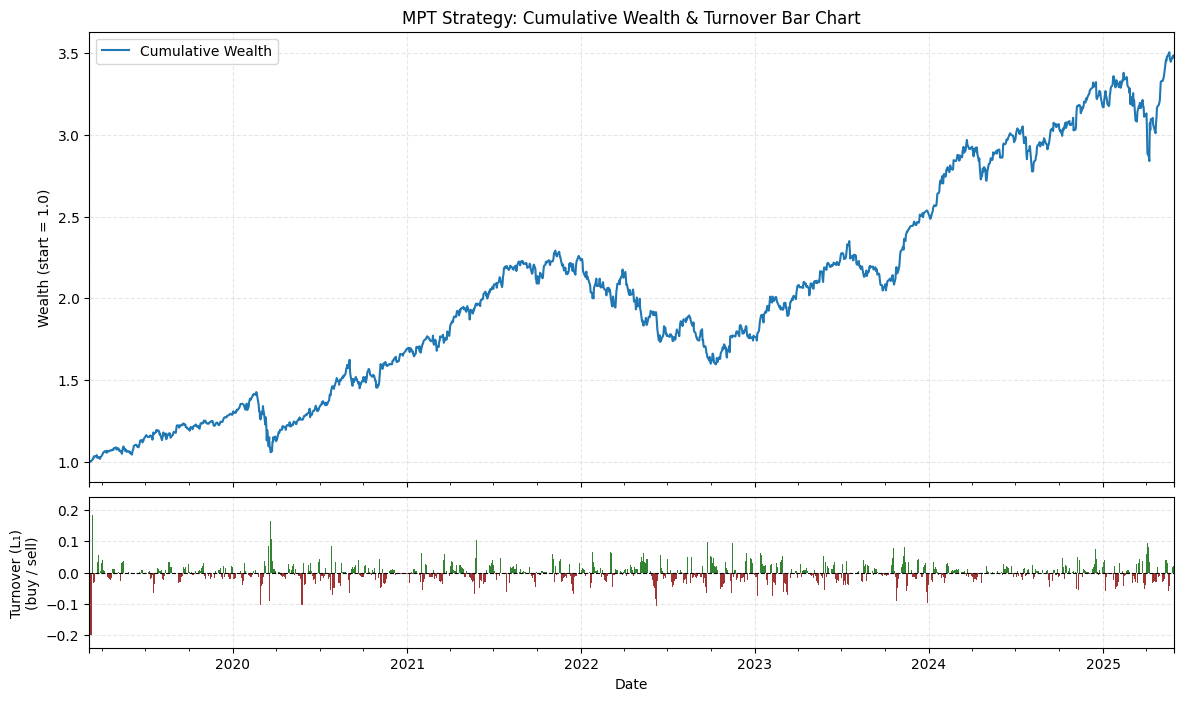

In [39]:
fig, ax1, ax2 = plot_mpt_rebalance_barchart(
    rolling_mpt,
    N=0,    
    figsize=(14, 8),
    bar_width=0.8,
    tol_days=1,     
    skip_days=0  
)

# Post-Hoc Analyses or smth

In [40]:
summary = summarize_backtest(
    rolling_mpt,
    cost_per_unit=0.001,    # 0.1% per unit turnover
    weight_threshold=0.01   # count only weights above 1% as “held”
)
print(summary.T)

                            0
Ann Return (%)      14.846203
Ann Volatility (%)  14.389816
Ann Sharpe           1.031716
Max Drawdown (%)   -30.395968
Calmar Ratio         0.488427
Sortino Ratio        1.011584
Avg Daily Turnover   0.021254
Total Turnover      48.437731
Avg # Holdings       5.843791
Total TC Drag (%)    4.843773


[*********************100%***********************]  1 of 1 completed


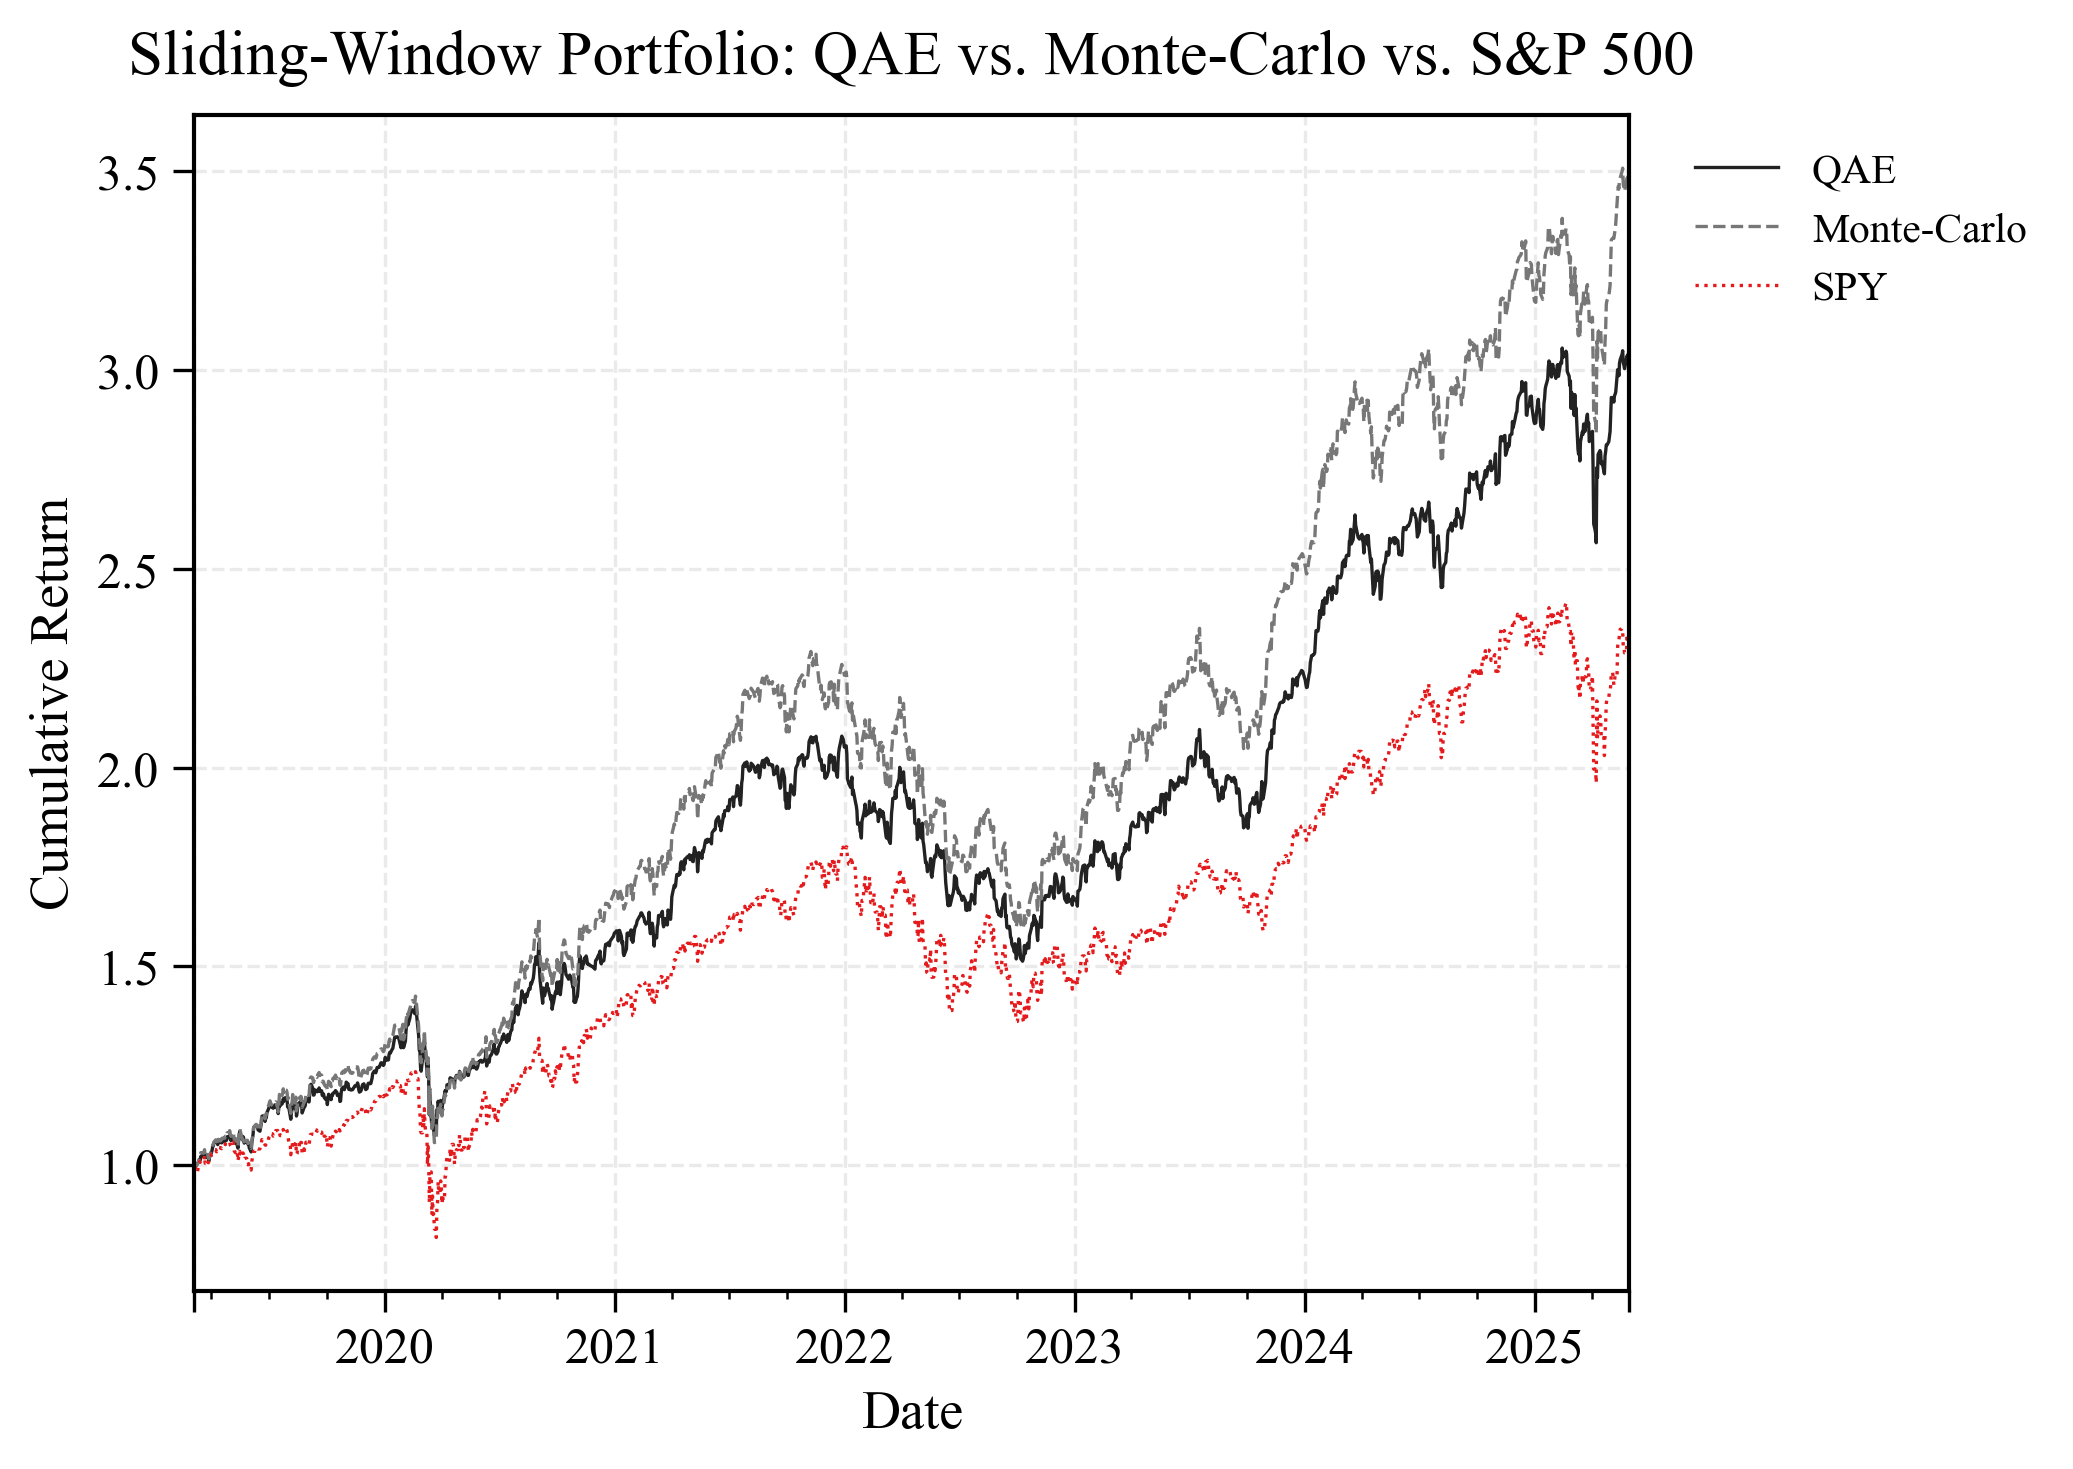

In [41]:
import yfinance as yf
import matplotlib.pyplot as plt

import yfinance as yf
import matplotlib.pyplot as plt

def compare_strategies_vs_benchmark(
    rolling_mpt1,
    rolling_mpt2,
    benchmark_ticker: str = "SPY",
    figsize: tuple[float, float] = (8, 5),
    colors: dict = None,
    linestyles: dict = None,
    title_fontsize: int = 18,
    label_fontsize: int = 14,
    tick_fontsize: int = 12,
    legend_fontsize: int = 12,
    dpi: int = 300,
    linewidth: float = 2.0
):
    """
    Plot cumulative‐wealth curves for two RollingPortfolio strategies 
    alongside a benchmark (e.g., SPY), styled for publication.

    Parameters
    ----------
    rolling_mpt1 : RollingPortfolio
        First backtested strategy (must have run run_backtest()).
    rolling_mpt2 : RollingPortfolio
        Second backtested strategy (must have run run_backtest()).
    benchmark_ticker : str, default="SPY"
        Ticker symbol for the benchmark (fetched via yfinance).
    figsize : tuple[float, float], default=(8, 5)
        Figure size in inches.
    colors : dict, optional
        Colors for each curve: keys = "strategy1", "strategy2", "benchmark".
        If None, default muted Tableau colors are used.
    linestyles : dict, optional
        Linestyles for each curve: keys = "strategy1", "strategy2", "benchmark".
        If None, defaults are {"strategy1":"-", "strategy2":"--", "benchmark":":"}.
    title_fontsize : int, default=18
        Font size for the title.
    label_fontsize : int, default=14
        Font size for axis labels.
    tick_fontsize : int, default=12
        Font size for tick labels.
    legend_fontsize : int, default=12
        Font size for legend entries.
    dpi : int, default=300
        Dots per inch for saving the figure.

    Returns
    -------
    fig, ax : matplotlib Figure and Axes
    """

    # 1) Extract daily returns for each strategy and align indices
    pnl1 = rolling_mpt1.portf_returns.dropna()
    pnl2 = rolling_mpt2.portf_returns.dropna()
    common_dates = pnl1.index.intersection(pnl2.index)
    pnl1 = pnl1.reindex(common_dates)
    pnl2 = pnl2.reindex(common_dates)

    # 2) Compute cumulative wealth for each strategy
    cum_wealth1 = (1 + pnl1).cumprod()
    cum_wealth2 = (1 + pnl2).cumprod()

    # 3) Fetch benchmark data over the same date range
    start_date = common_dates.min()
    end_date   = common_dates.max()
    bench_prices = yf.download(benchmark_ticker, start=start_date, end=end_date)["Close"]
    bench_ret    = bench_prices.pct_change().reindex(common_dates).fillna(0)
    bench_cum    = (1 + bench_ret).cumprod()

    # 4) Set default colors and linestyles if not provided
    if colors is None:
        colors = {
            "strategy1": "#4C72B0",  # muted blue
            "strategy2": "#DD8452",  # muted orange
            "benchmark": "#55A868"   # muted green
        }
    if linestyles is None:
        linestyles = {
            "strategy1": "-",
            "strategy2": "--",
            "benchmark": ":"
        }

    # 5) Configure rcParams for publication‐quality styling
    plt.rcParams.update({
        "font.family":       "serif",
        "font.serif":        ["Times New Roman", "Palatino", "serif"],
        "axes.titlesize":    title_fontsize,
        "axes.labelsize":    label_fontsize,
        "xtick.labelsize":   tick_fontsize,
        "ytick.labelsize":   tick_fontsize,
        "legend.fontsize":   legend_fontsize,
        "figure.dpi":        dpi,
        "axes.linewidth":    1.0,
        "xtick.major.size":  5,
        "ytick.major.size":  5,
        "xtick.major.width": 0.8,
        "ytick.major.width": 0.8,
        "axes.grid":         True,
        "grid.color":        "#999999",
        "grid.alpha":        0.2,
        "grid.linestyle":    "--"
    })

    # 6) Create figure and axis
    fig, ax = plt.subplots(figsize=figsize)

    # 7) Plot each cumulative wealth curve
    cum_wealth1.plot(
        ax=ax,
        label="QAE",
        color=colors["strategy1"],
        linestyle=linestyles["strategy1"],
        linewidth=linewidth
    )
    cum_wealth2.plot(
        ax=ax,
        label="Monte-Carlo",
        color=colors["strategy2"],
        linestyle=linestyles["strategy2"],
        linewidth=linewidth
    )
    bench_cum.plot(
        ax=ax,
        label=f"{benchmark_ticker} Buy-&-Hold",
        color=colors["benchmark"],
        linestyle=linestyles["benchmark"],
        linewidth=linewidth
    )

    # 8) Add title and axis labels
    ax.set_title("Sliding-Window Portfolio: QAE vs. Monte-Carlo vs. S&P 500", pad=10)
    ax.set_xlabel("Date", fontsize=label_fontsize)
    ax.set_ylabel("Cumulative Return", fontsize=label_fontsize)

    # 9) Draw a light grid (already enabled via rcParams)
    ax.grid(True, which="major", linestyle="--", alpha=0.2)

    # 10) Place legend outside the upper‐left of the plot area
    ax.legend(
        loc="upper left",
        bbox_to_anchor=(1.02, 1.0),
        frameon=False
    )

    # 11) Tight layout, reserving space for the legend
    plt.tight_layout(rect=[0, 0, 0.88, 1.0])

    return fig, ax



colors_set1 = {
    "strategy1": "#e41a1c",  # red
    "strategy2": "#377eb8",  # blue
    "benchmark": "#4daf4a"   # green
}
colors_gray_accent = {
    "strategy1": "#222222",  # dark gray
    "strategy2": "#777777",  # medium gray
    "benchmark": "#e41a1c"   # red accent
}
colors_okabe_ito = {
    "strategy1": "#E69F00",  # bright orange
    "strategy2": "#56B4E9",  # sky blue
    "benchmark":  "#009E73"   # bluish‐green
}


fig, ax = compare_strategies_vs_benchmark(
    quantum_mpt,        # quantum
    rolling_mpt,        # classical
    benchmark_ticker="SPY",
    colors=colors_gray_accent,
    linestyles={"strategy1":"-", "strategy2":"--", "benchmark":":"},
    figsize=(8, 5),
    title_fontsize=15,
    label_fontsize=13,
    tick_fontsize=12,
    legend_fontsize=10,
    dpi=300,
    linewidth=0.8
)


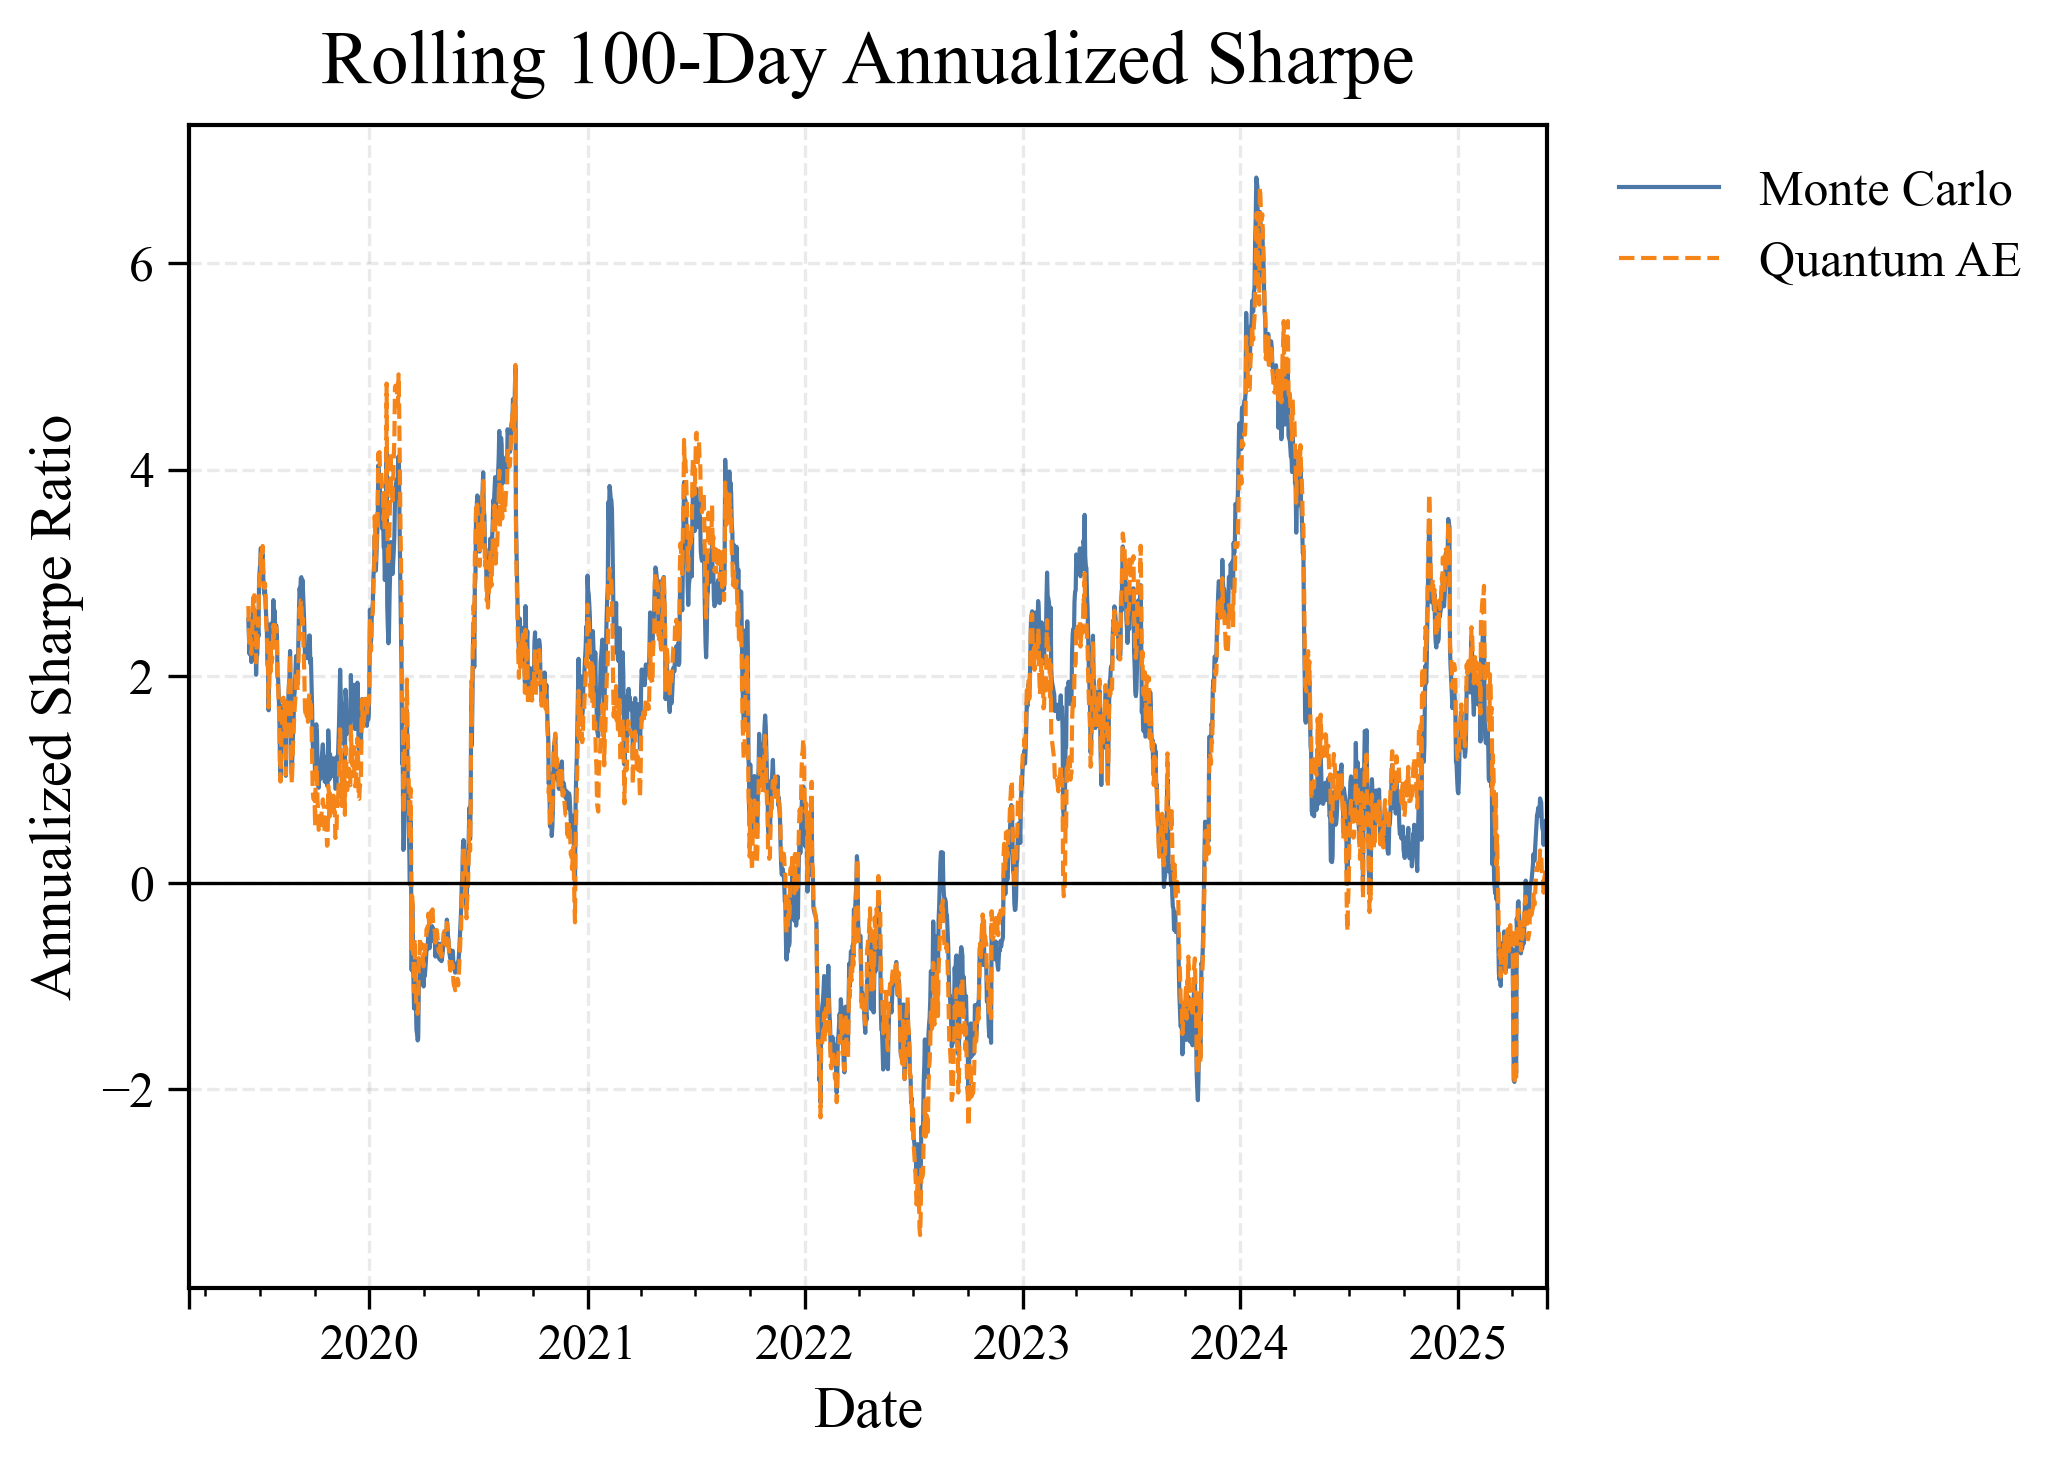

In [42]:
fig, ax = plot_rolling_sharpe_comparison(
    rolling_mpt1=rolling_mpt,
    rolling_mpt2=quantum_mpt,
    window=100,
    labels=("Monte Carlo", "Quantum AE"),
    colors=("#4C78A8", "#F58518"),       # Tableau 10 muted blue & orange
    linestyles=("-", "--"),
    linewidths=(1.0, 1.0),               # thinner lines for print
    figsize=(8, 5),
    title_fontsize=18,
    label_fontsize=14,
    tick_fontsize=12,
    legend_fontsize=12,
    dpi=300
)

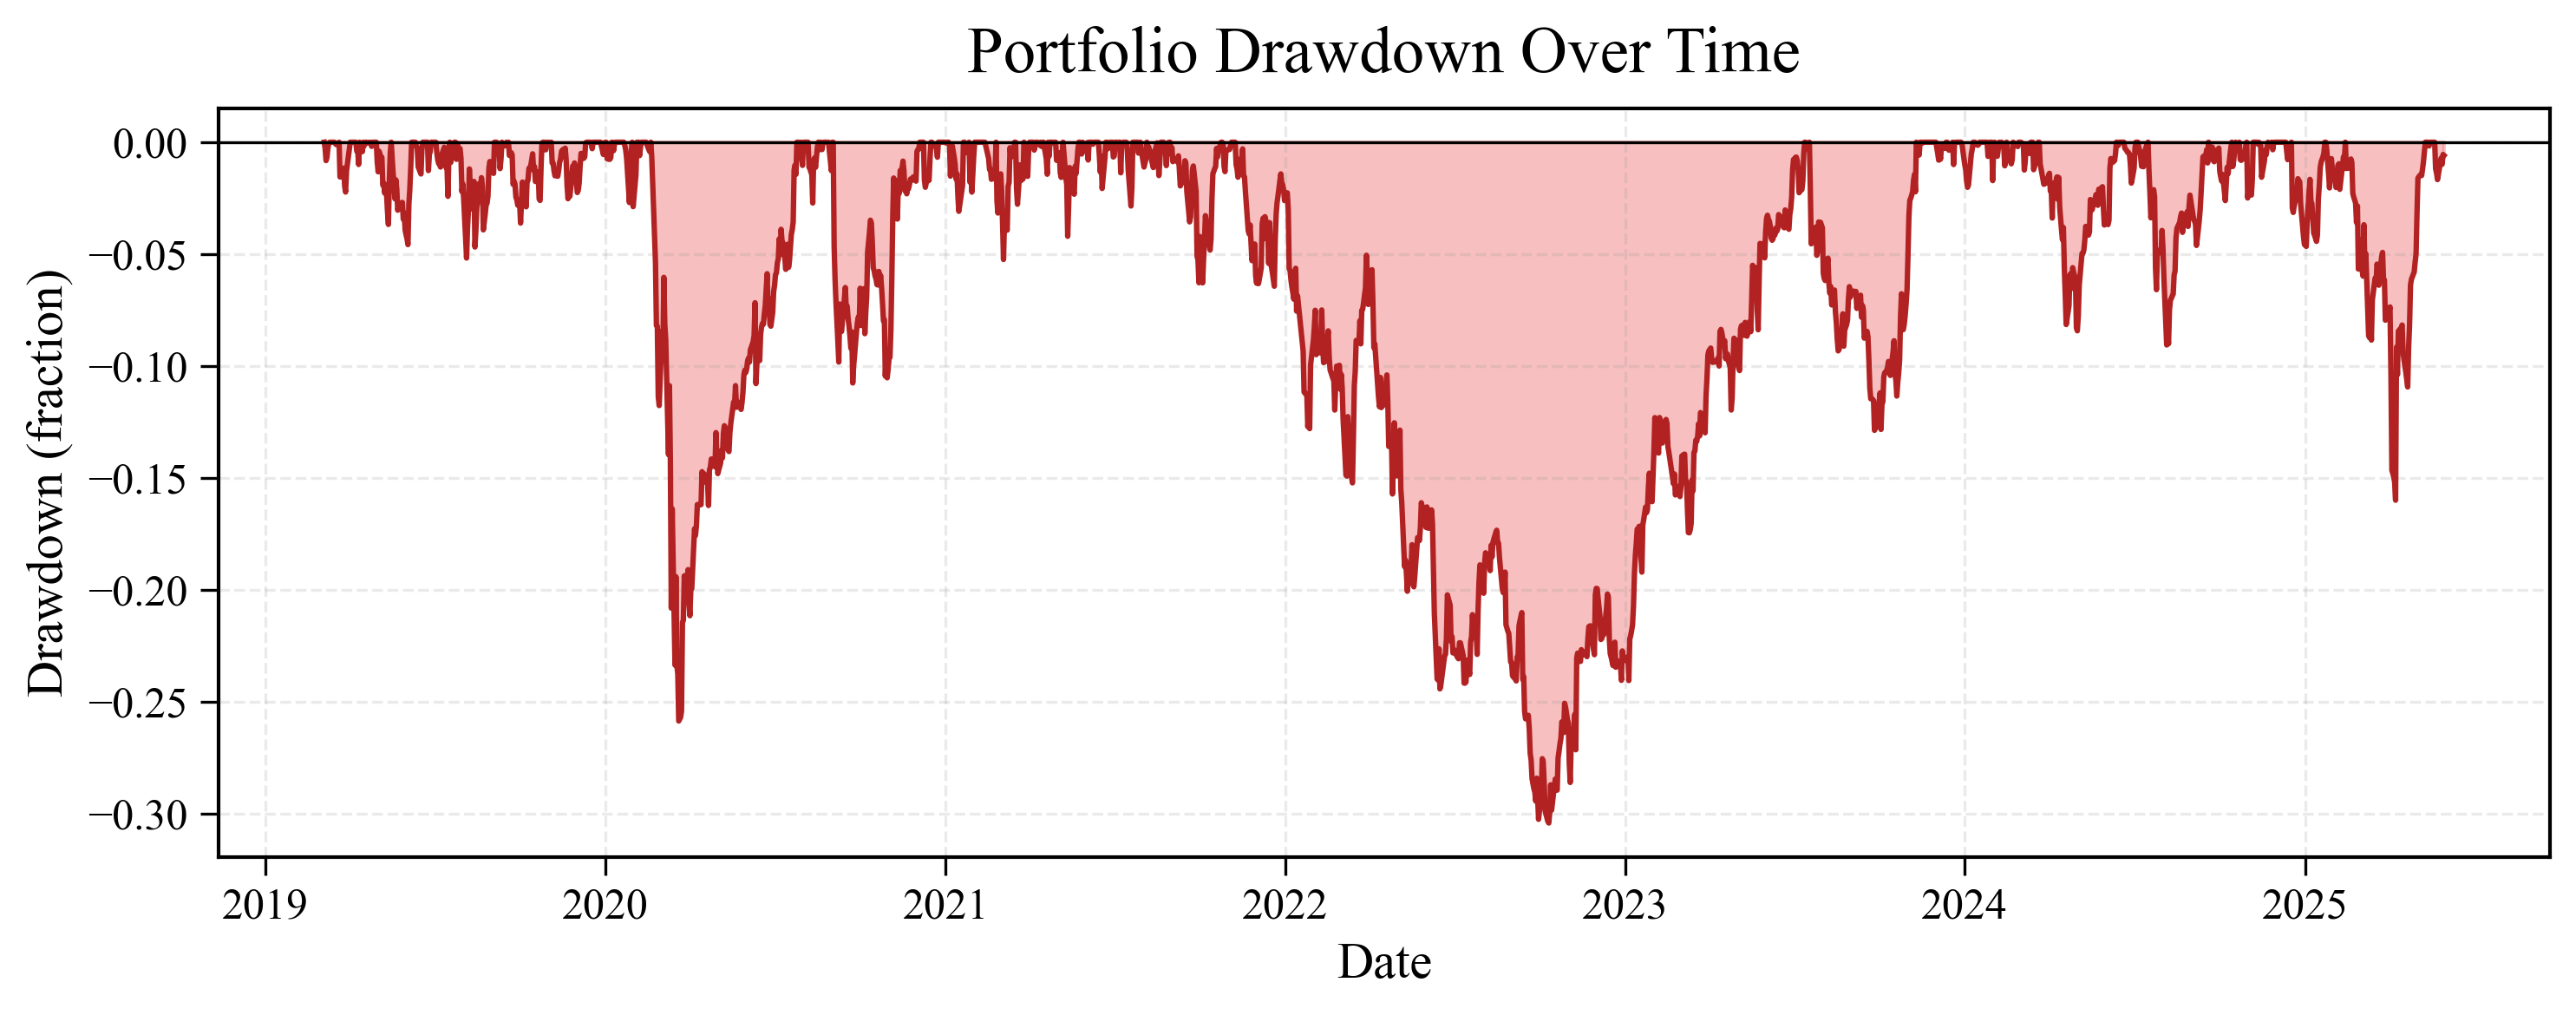

In [43]:
fig, ax = plot_drawdown(
    rolling_mpt,
    figsize=(10, 4),
    title="Portfolio Drawdown Over Time",
    title_fontsize=18,
    label_fontsize=14,
    tick_fontsize=12,
    dpi=300
)

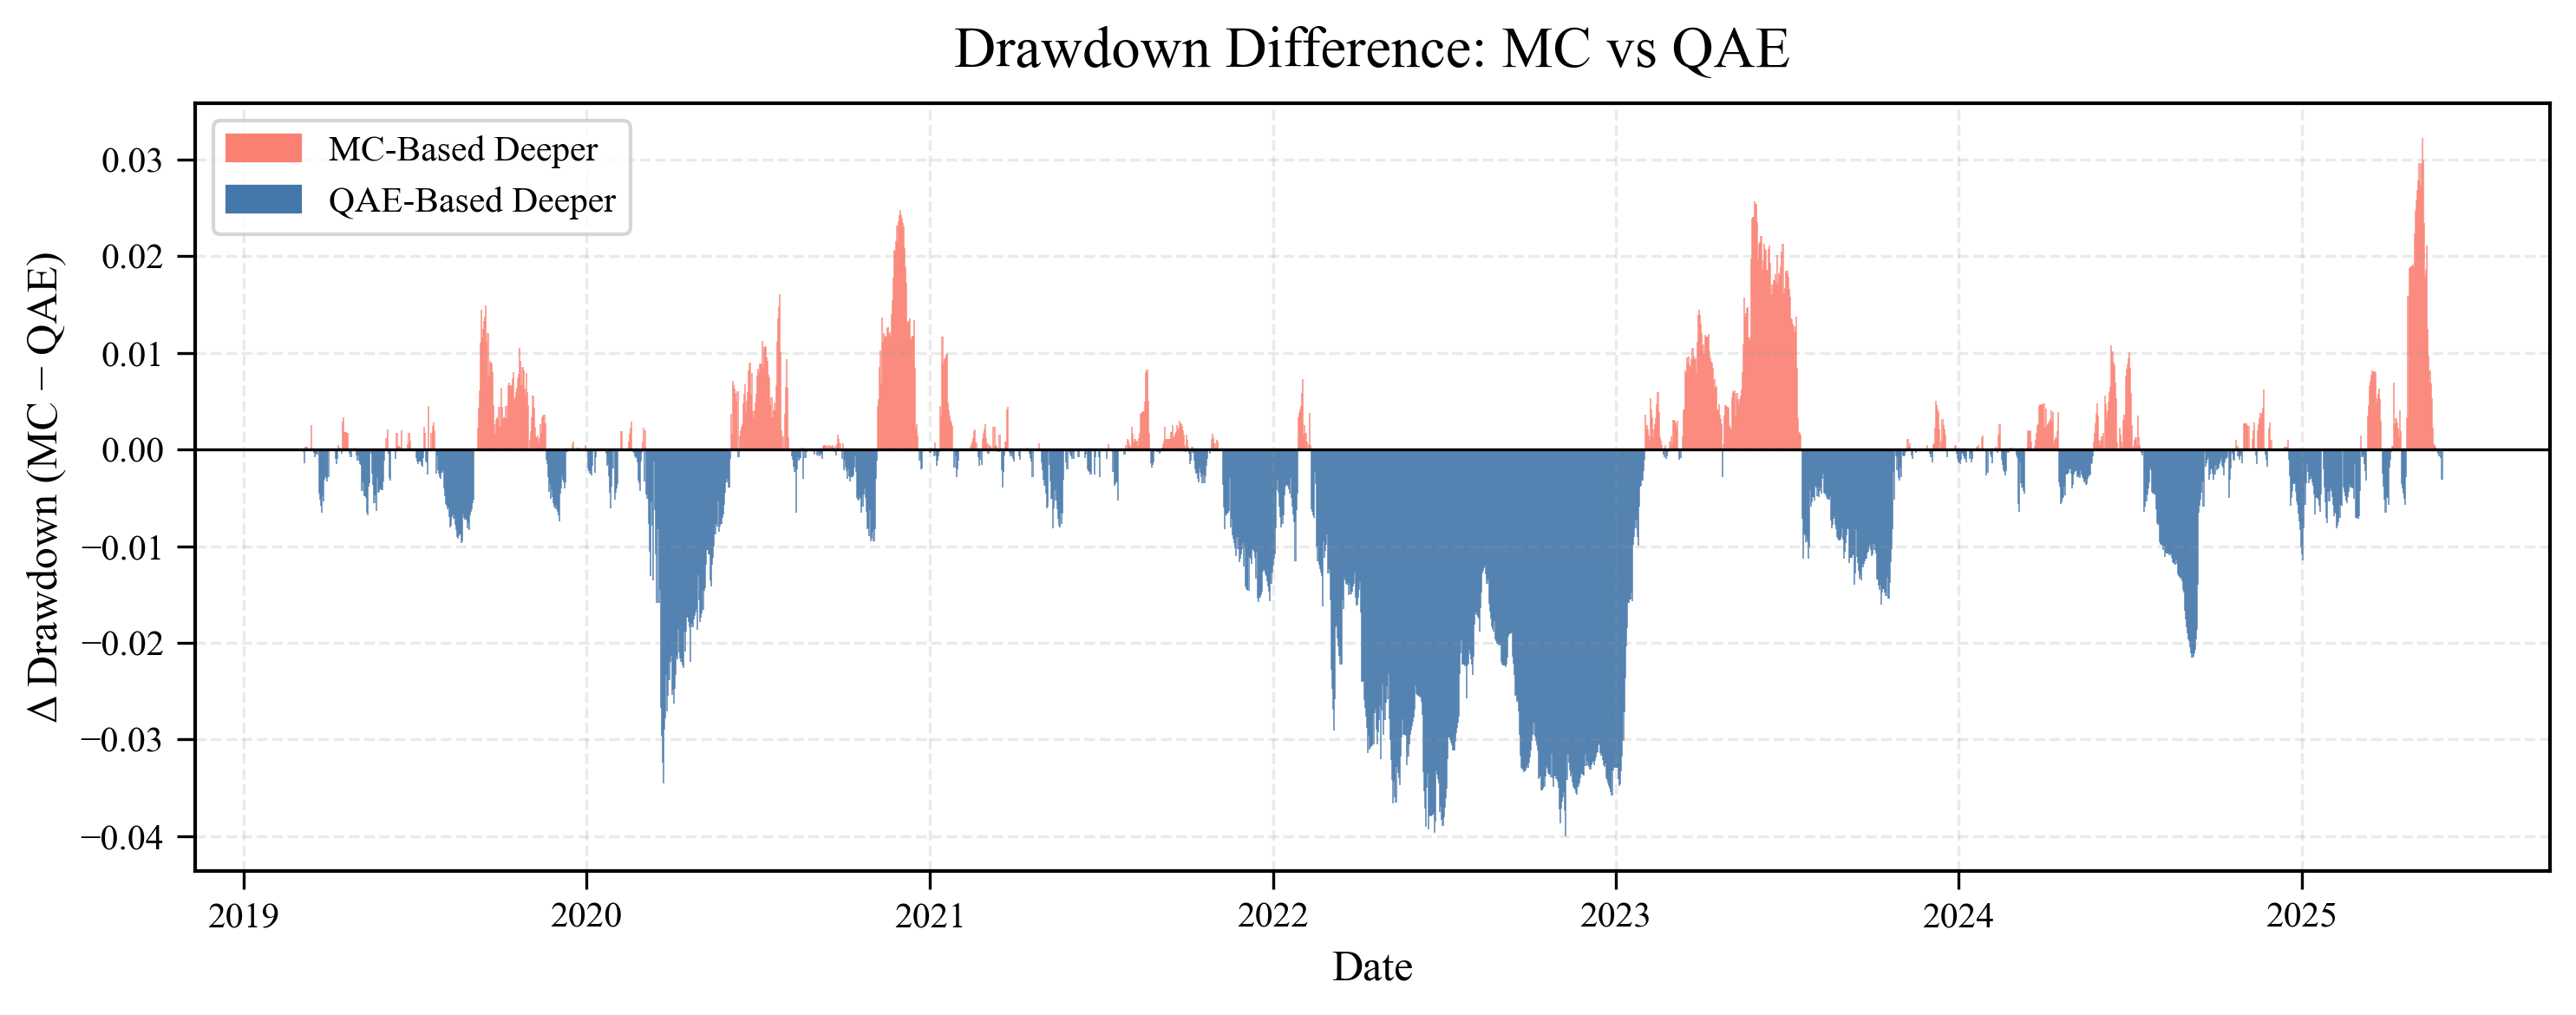

In [44]:
import numpy as np
import matplotlib.pyplot as plt

def plot_drawdown_difference(
    rolling_mc,
    rolling_qae,
    label_mc: str = "MC-Based",
    label_qae: str = "QAE-Based",
    figsize: tuple[float, float] = (10, 4),
    title: str = "Drawdown Difference (MC − QAE)",
    title_fontsize: int = 16,
    label_fontsize: int = 12,
    tick_fontsize: int = 10,
    legend_fontsize: int = 10,
    dpi: int = 300,
):
    """
    Plot only the difference between two drawdown series:
      ΔDD(t) = Drawdown_MC(t) − Drawdown_QAE(t).

    A positive bar (salmon) means MC is deeper in drawdown (worse);
    a negative bar (steel-blue) means QAE is deeper in drawdown (worse).

    Parameters
    ----------
    rolling_mc : RollingPortfolio
        “Monte Carlo” strategy (portf_returns must be populated).
    rolling_qae : RollingPortfolio
        “Quantum AE” strategy (portf_returns must be populated).
    label_mc : str, default="MC-Based"
        Label used in the legend for MC drawdown.
    label_qae : str, default="QAE-Based"
        Label used in the legend for QAE drawdown.
    figsize : tuple[float, float], default=(10, 4)
        Figure size in inches.
    title : str, default="Drawdown Difference (MC − QAE)"
        Plot title.
    title_fontsize : int, default=16
        Font size for the title.
    label_fontsize : int, default=12
        Font size for axis labels.
    tick_fontsize : int, default=10
        Font size for tick labels.
    legend_fontsize : int, default=10
        Font size for the legend.
    dpi : int, default=300
        Dots per inch for saving/displaying the figure.

    Returns
    -------
    fig, ax : matplotlib Figure and Axes
    """

    # 1) Helper to compute drawdown from portf_returns
    def _compute_drawdown(returns_series):
        """
        Given a pandas Series of daily returns (indexed by date),
        compute drawdown(t) = (cumwealth(t) / running_max) − 1.
        """
        cum_wealth = (1 + returns_series).cumprod()
        running_max = cum_wealth.cummax()
        return cum_wealth / running_max - 1.0

    # Compute each drawdown series
    dd_mc_raw  = _compute_drawdown(rolling_mc.portf_returns.dropna())
    dd_qae_raw = _compute_drawdown(rolling_qae.portf_returns.dropna())

    # Align dates
    common_idx = dd_mc_raw.index.intersection(dd_qae_raw.index)
    dd_mc  = dd_mc_raw.reindex(common_idx).fillna(0)
    dd_qae = dd_qae_raw.reindex(common_idx).fillna(0)

    # 2) Compute difference: positive → MC deeper; negative → QAE deeper
    dd_diff = dd_mc - dd_qae

    # 3) Configure rcParams for publication‐quality styling
    plt.rcParams.update({
        "font.family":       "serif",
        "font.serif":        ["Times New Roman", "Palatino", "serif"],
        "axes.titlesize":    title_fontsize,
        "axes.labelsize":    label_fontsize,
        "xtick.labelsize":   tick_fontsize,
        "ytick.labelsize":   tick_fontsize,
        "legend.fontsize":   legend_fontsize,
        "figure.dpi":        dpi,
        "axes.linewidth":    1.0,
        "xtick.major.size":  5,
        "ytick.major.size":  5,
        "xtick.major.width": 0.8,
        "ytick.major.width": 0.8,
        "axes.grid":         True,
        "grid.color":        "#999999",
        "grid.alpha":        0.2,
        "grid.linestyle":    "--"
    })

    # 4) Create figure and axis
    fig, ax = plt.subplots(figsize=figsize)

    # 5) Define bar colors based on sign of dd_diff
    #    - Positive (MC deeper): salmon
    #    - Negative (QAE deeper): steel-blue
    bar_colors = np.where(dd_diff.values >= 0, "salmon", "#4477AA")

    # 6) Plot the difference as vertical bars
    ax.bar(
        common_idx,
        dd_diff.values,
        width=2,                # approx. 2 trading days
        color=bar_colors,
        alpha=0.7,
        edgecolor="none"
    )

    # 7) Horizontal zero line
    ax.axhline(0, color="black", lw=0.8)

    # 8) Labels and title
    ax.set_title(title, pad=10)
    ax.set_ylabel("Δ Drawdown (MC − QAE)", fontsize=label_fontsize)
    ax.set_xlabel("Date", fontsize=label_fontsize)

    # 9) Annotate legend entry indicating which color means what
    import matplotlib.patches as mpatches
    mc_patch  = mpatches.Patch(color="salmon", label=f"{label_mc} Deeper")
    qae_patch = mpatches.Patch(color="#4477AA", label=f"{label_qae} Deeper")
    ax.legend(handles=[mc_patch, qae_patch], loc="upper left", fontsize=legend_fontsize)

    # 10) Tight layout
    plt.tight_layout()

    return fig, ax

fig, ax = plot_drawdown_difference(
    rolling_mc=rolling_mpt,
    rolling_qae=quantum_mpt,
    label_mc="MC-Based",
    label_qae="QAE-Based",
    title="Drawdown Difference: MC vs QAE",
    figsize=(10, 4),
    title_fontsize=16,
    label_fontsize=12,
    tick_fontsize=10,
    legend_fontsize=10,
    dpi=300
)


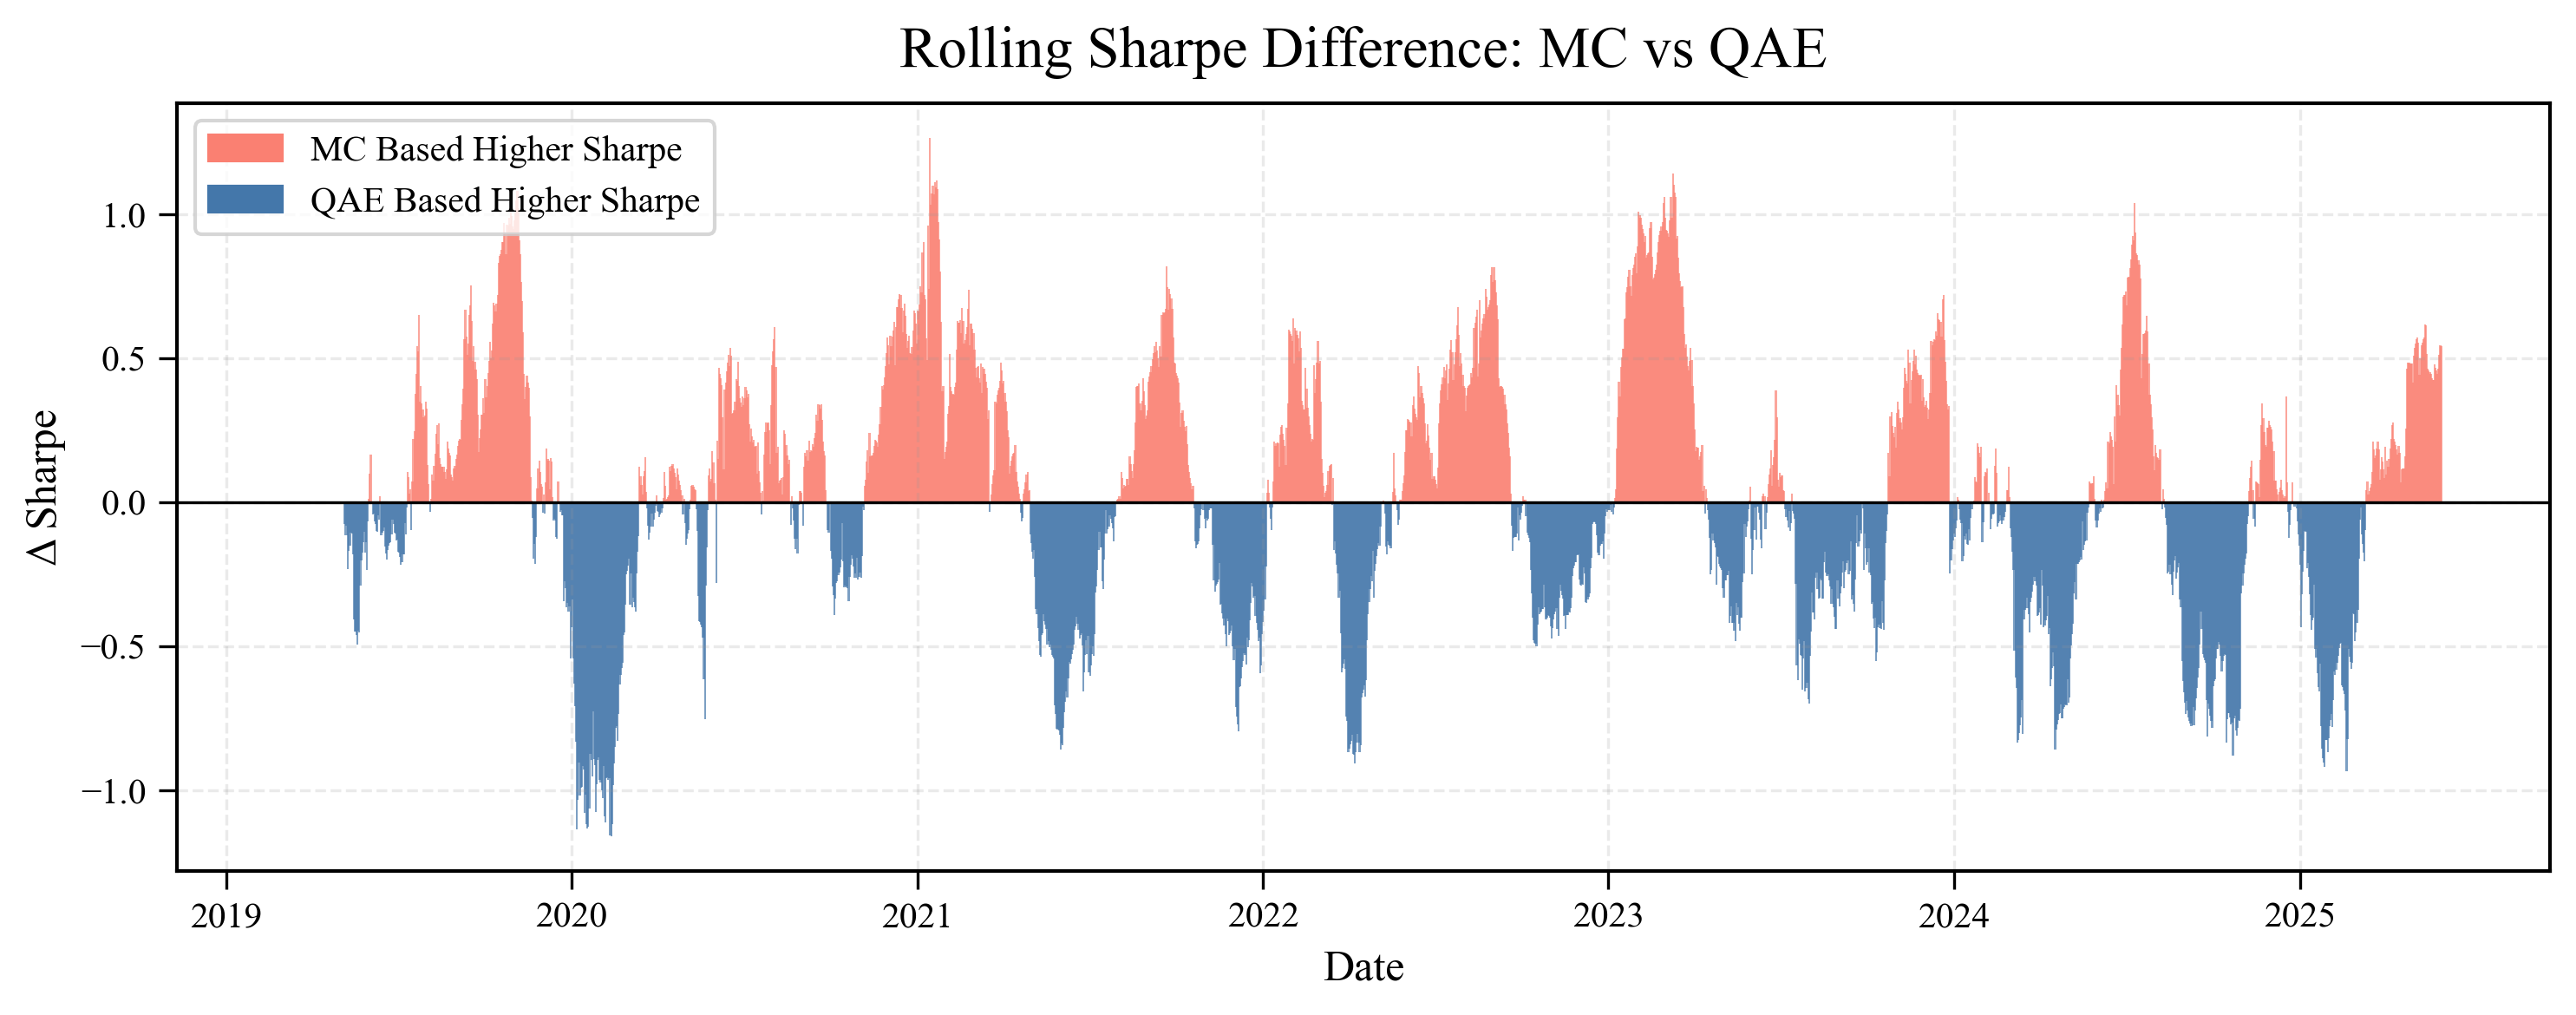

In [45]:

def plot_rolling_sharpe_difference(
    rolling_mpt1,
    rolling_mpt2,
    window: int = 63,
    label1: str = "Strategy 1",
    label2: str = "Strategy 2",
    figsize: tuple[float, float] = (10, 4),
    title: str = "Rolling Sharpe Difference (S1 − S2)",
    title_fontsize: int = 16,
    label_fontsize: int = 12,
    tick_fontsize: int = 10,
    legend_fontsize: int = 10,
    dpi: int = 300,
):
    """
    Plot the difference between two rolling‐Sharpe series:
       ΔSharpe(t) = Sharpe1(t) − Sharpe2(t).

    Positive bars (salmon) mean Strategy 1 has a higher Sharpe than Strategy 2.
    Negative bars (steel‐blue) mean Strategy 2 has a higher Sharpe.

    Parameters
    ----------
    rolling_mpt1 : RollingPortfolio
        First backtested strategy (must have run run_backtest()).
    rolling_mpt2 : RollingPortfolio
        Second backtested strategy (must have run run_backtest()).
    window : int, default=63
        Rolling window length (in trading days) to compute Sharpe (≈3 months).
    label1 : str, default="Strategy 1"
        Legend label / reference name for rolling_mpt1.
    label2 : str, default="Strategy 2"
        Legend label / reference name for rolling_mpt2.
    figsize : (width, height), default=(10, 4)
        Figure size in inches.
    title : str, default="Rolling Sharpe Difference (S1 − S2)"
        Plot title.
    title_fontsize : int, default=16
        Font size for the title.
    label_fontsize : int, default=12
        Font size for axis labels.
    tick_fontsize : int, default=10
        Font size for tick labels.
    legend_fontsize : int, default=10
        Font size for the legend text.
    dpi : int, default=300
        Dots per inch for high‐resolution output.

    Returns
    -------
    fig, ax : matplotlib Figure and Axes
    """

    # 1) Extract daily returns and align indices
    pnl1 = rolling_mpt1.portf_returns.dropna()
    pnl2 = rolling_mpt2.portf_returns.dropna()
    common_idx = pnl1.index.intersection(pnl2.index)
    pnl1 = pnl1.reindex(common_idx)
    pnl2 = pnl2.reindex(common_idx)

    # 2) Compute rolling annualized Sharpe for each series
    rolling_mean1 = pnl1.rolling(window).mean() * 252
    rolling_std1 = pnl1.rolling(window).std() * np.sqrt(252)
    rolling_sharpe1 = rolling_mean1 / rolling_std1

    rolling_mean2 = pnl2.rolling(window).mean() * 252
    rolling_std2 = pnl2.rolling(window).std() * np.sqrt(252)
    rolling_sharpe2 = rolling_mean2 / rolling_std2

    # 3) Align Sharpe series to common index and fill any NaNs with 0
    rs1 = rolling_sharpe1.reindex(common_idx).fillna(0)
    rs2 = rolling_sharpe2.reindex(common_idx).fillna(0)

    # 4) Compute difference: ΔSharpe(t) = rs1 − rs2
    sharpe_diff = rs1 - rs2

    # 5) Configure rcParams for publication‐quality styling
    plt.rcParams.update({
        "font.family":       "serif",
        "font.serif":        ["Times New Roman", "Palatino", "serif"],
        "axes.titlesize":    title_fontsize,
        "axes.labelsize":    label_fontsize,
        "xtick.labelsize":   tick_fontsize,
        "ytick.labelsize":   tick_fontsize,
        "legend.fontsize":   legend_fontsize,
        "figure.dpi":        dpi,
        "axes.linewidth":    1.0,
        "xtick.major.size":  5,
        "ytick.major.size":  5,
        "xtick.major.width": 0.8,
        "ytick.major.width": 0.8,
        "axes.grid":         True,
        "grid.color":        "#999999",
        "grid.alpha":        0.2,
        "grid.linestyle":    "--"
    })

    # 6) Create figure and axis
    fig, ax = plt.subplots(figsize=figsize)

    # 7) Determine bar colors by sign of sharpe_diff
    #    Positive → Strategy1 better (salmon), Negative → Strategy2 better (steel‐blue)
    bar_colors = np.where(sharpe_diff.values >= 0, "salmon", "#4477AA")

    # 8) Plot as vertical bars
    ax.bar(
        common_idx,
        sharpe_diff.values,
        width=2,            # ~2 trading days wide
        color=bar_colors,
        alpha=0.7,
        edgecolor="none"
    )

    # 9) Add horizontal zero line
    ax.axhline(0, color="black", lw=0.8)

    # 10) Labels and title
    ax.set_title(title, pad=10)
    ax.set_ylabel("Δ Sharpe", fontsize=label_fontsize)
    ax.set_xlabel("Date", fontsize=label_fontsize)

    # 11) Create legend manually (two patches)
    import matplotlib.patches as mpatches
    patch1 = mpatches.Patch(color="salmon", label=f"{label1} Higher Sharpe")
    patch2 = mpatches.Patch(color="#4477AA", label=f"{label2} Higher Sharpe")
    ax.legend(handles=[patch1, patch2], loc="upper left", fontsize=legend_fontsize)

    # 12) Tight layout
    plt.tight_layout()

    return fig, ax
fig, ax = plot_rolling_sharpe_difference(
    rolling_mpt1=rolling_mpt,
    rolling_mpt2=quantum_mpt,
    window=63,
    label1="MC Based",
    label2="QAE Based",
    title="Rolling Sharpe Difference: MC vs QAE",
    figsize=(10, 4),
    title_fontsize=16,
    label_fontsize=12,
    tick_fontsize=10,
    legend_fontsize=10,
    dpi=300
)

(<Figure size 3000x1200 with 1 Axes>,
 <Axes: title={'center': '100-Day Rolling Return Δ (MC − QAE)'}, xlabel='Date', ylabel='Δ Rolling Return'>)

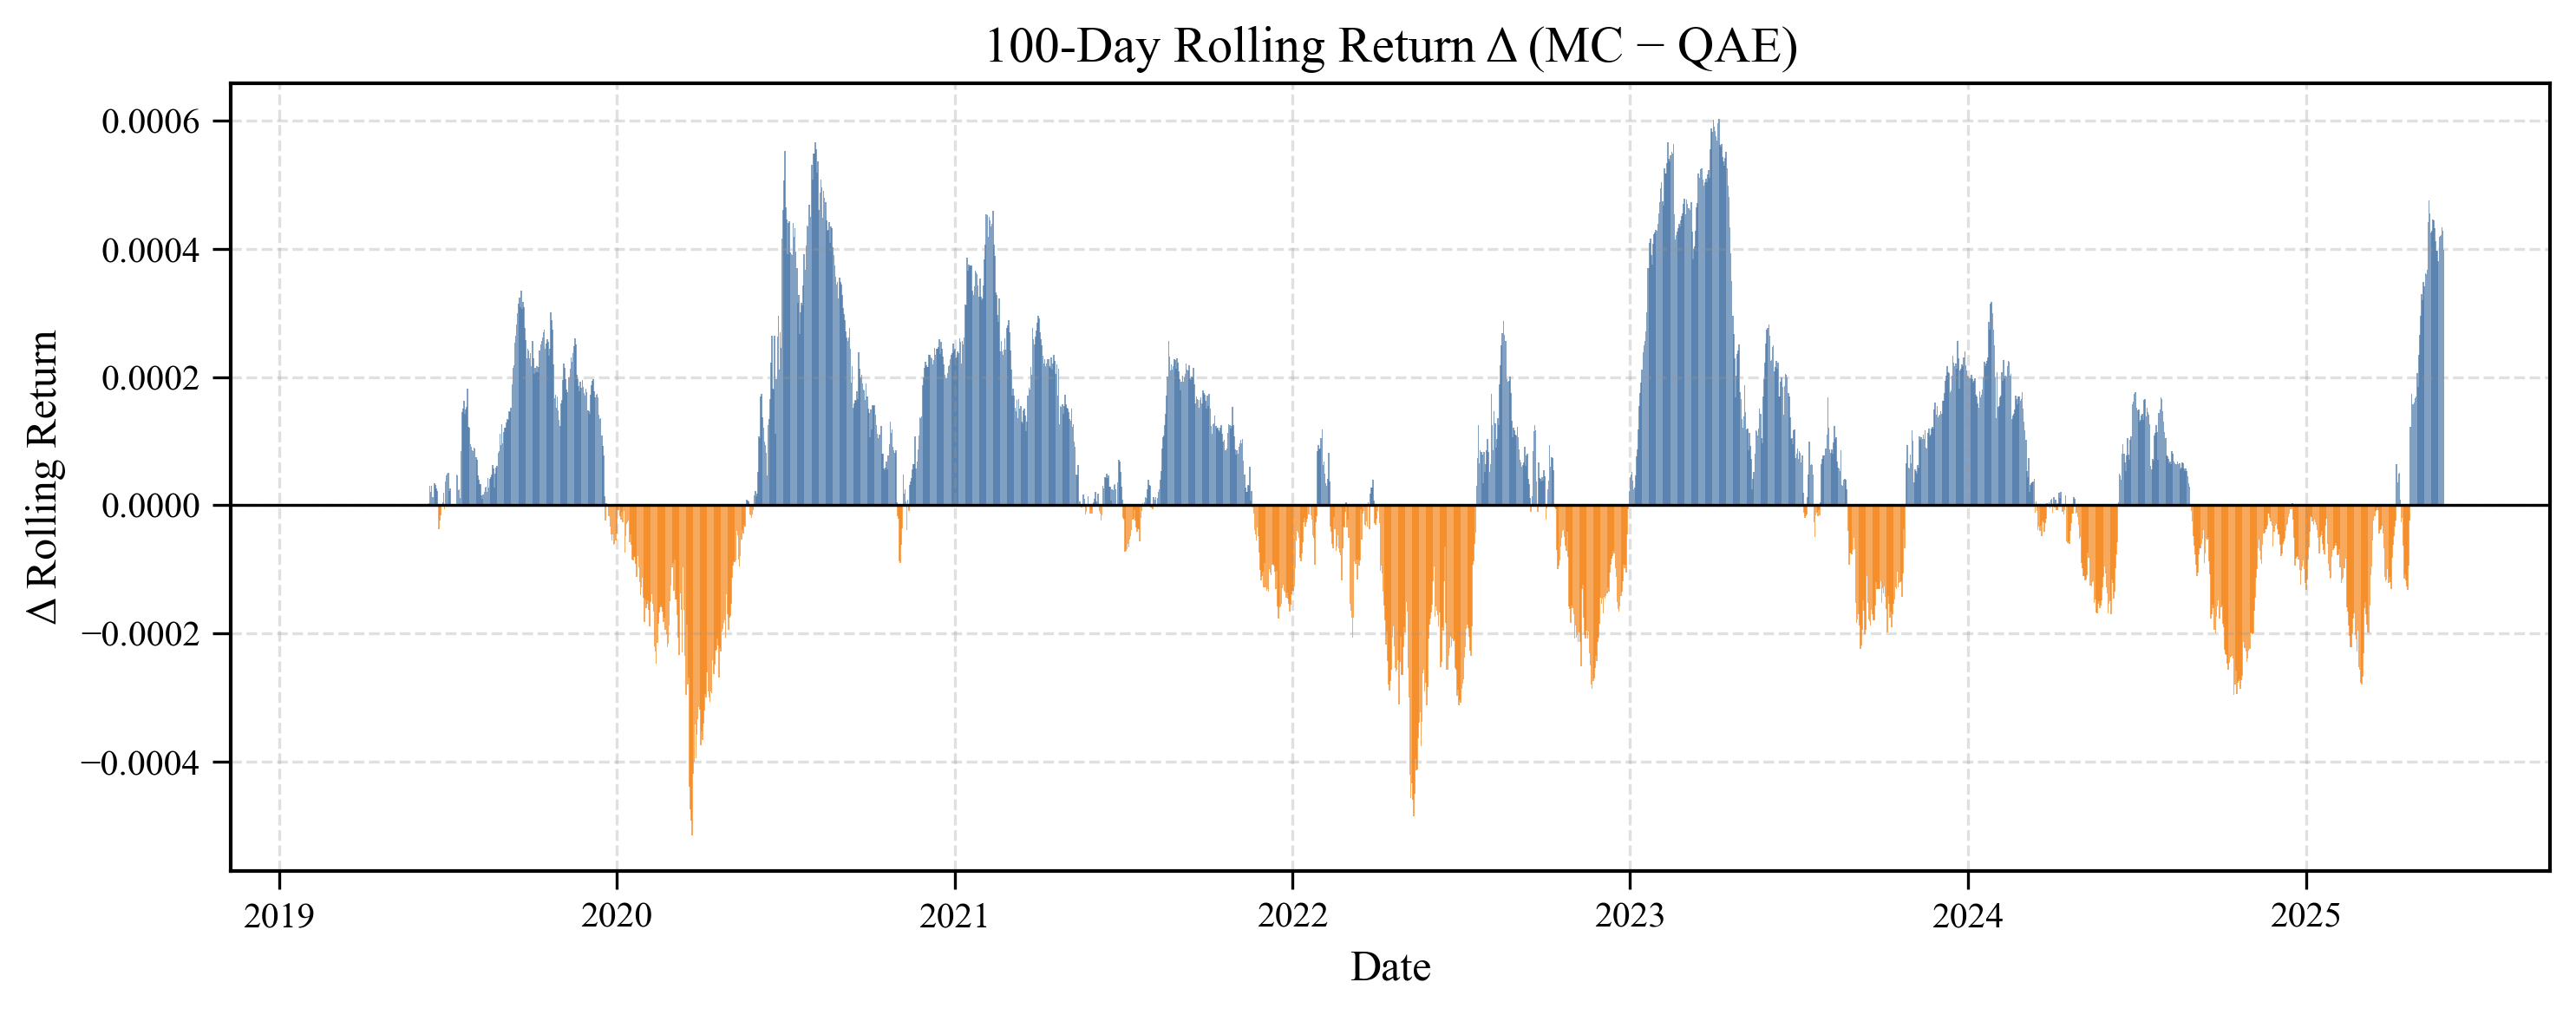

In [46]:
def plot_rolling_return_difference(rolling_mc, rolling_qae, window=21, figsize=(10,4), dpi=300):
    # 1) Get returns and align
    pnl1 = rolling_mc.portf_returns.dropna()
    pnl2 = rolling_qae.portf_returns.dropna()
    common_idx = pnl1.index.intersection(pnl2.index)
    pnl1 = pnl1.reindex(common_idx)
    pnl2 = pnl2.reindex(common_idx)

    # 2) Compute rolling‐window average returns
    rr1 = pnl1.rolling(window).mean()
    rr2 = pnl2.rolling(window).mean()
    rr1 = rr1.reindex(common_idx).fillna(0)
    rr2 = rr2.reindex(common_idx).fillna(0)
    delta_rr = rr1 - rr2

    # 3) Plot as bars
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    colors = np.where(delta_rr.values >= 0, "#4C78A8", "#F58518")
    ax.bar(common_idx, delta_rr.values, width=1.5, color=colors, alpha=0.7)
    ax.axhline(0, color="black", lw=0.8)
    ax.set_title(f"{window}-Day Rolling Return Δ (MC − QAE)", fontsize=14)
    ax.set_ylabel("Δ Rolling Return", fontsize=12)
    ax.set_xlabel("Date", fontsize=12)
    ax.grid(True, linestyle="--", alpha=0.3)
    plt.tight_layout()
    return fig, ax

plot_rolling_return_difference(rolling_mpt, quantum_mpt, window=100)

(<Figure size 3000x1200 with 1 Axes>,
 <Axes: title={'center': '100-Day Rolling Volatility Δ (MC − QAE)'}, xlabel='Date', ylabel='Δ Volatility (annualized)'>)

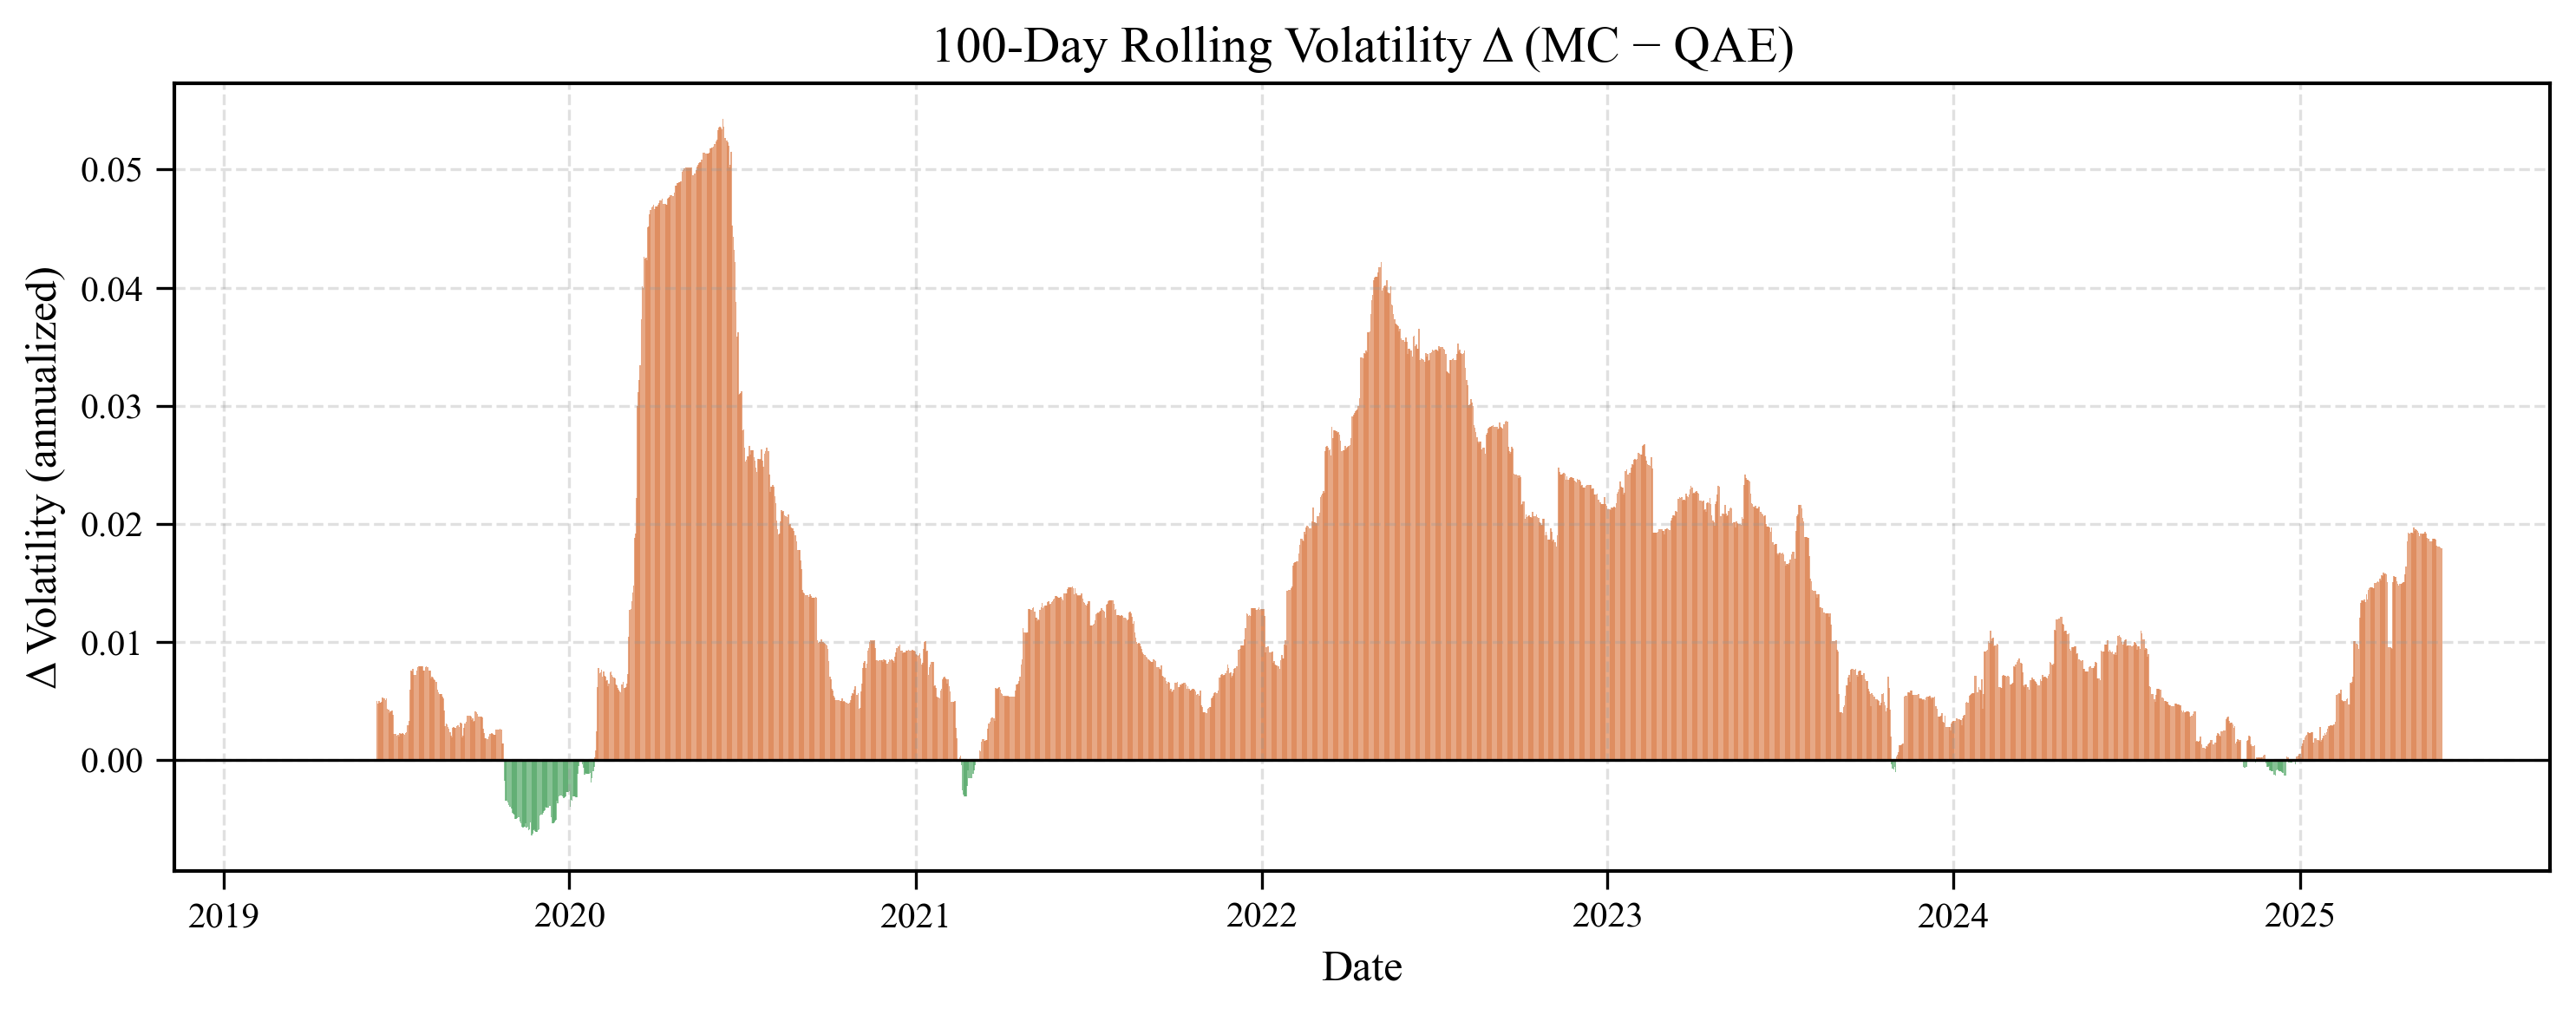

In [47]:
def plot_rolling_volatility_difference(rolling_mc, rolling_qae, window=21, figsize=(10,4), dpi=300):
    pnl1 = rolling_mc.portf_returns.dropna()
    pnl2 = rolling_qae.portf_returns.dropna()
    common_idx = pnl1.index.intersection(pnl2.index)
    pnl1 = pnl1.reindex(common_idx)
    pnl2 = pnl2.reindex(common_idx)

    vol1 = pnl1.rolling(window).std() * np.sqrt(252)   # annualized
    vol2 = pnl2.rolling(window).std() * np.sqrt(252)
    vol1 = vol1.reindex(common_idx).fillna(0)
    vol2 = vol2.reindex(common_idx).fillna(0)
    delta_vol = vol1 - vol2

    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    colors = np.where(delta_vol.values >= 0, "#DD8452", "#55A868")
    ax.bar(common_idx, delta_vol.values, width=1.5, color=colors, alpha=0.7)
    ax.axhline(0, color="black", lw=0.8)
    ax.set_title(f"{window}-Day Rolling Volatility Δ (MC − QAE)", fontsize=14)
    ax.set_ylabel("Δ Volatility (annualized)", fontsize=12)
    ax.set_xlabel("Date", fontsize=12)
    ax.grid(True, linestyle="--", alpha=0.3)
    plt.tight_layout()
    return fig, ax

plot_rolling_volatility_difference(rolling_mpt, quantum_mpt, window=100)

In [48]:
fig, (ax_mu, ax_var) = compare_mc_qae_estimation_errors(
    all_estimates_df = classical_estimation_data,
    prices           = prices,
    lambda_risk      = 2.0,             # or whatever λ you used
    aggregator       = "uniform",       # or "hindsight_optimal"
    figsize          = (10, 6),
    title_fontsize   = 16,
    label_fontsize   = 12,
    tick_fontsize    = 10,
    legend_fontsize  = 10,
    dpi              = 300
)

plt.show()

NameError: name 'classical_estimation_data' is not defined

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_realized_utility_difference(
    weights_mc: pd.DataFrame,
    weights_qae: pd.DataFrame,
    returns: pd.DataFrame,
    true_covariance: dict[pd.Timestamp, np.ndarray],
    lambda_risk: float,
    figsize: tuple[float, float] = (10, 4),
    title: str = "Realized Utility Difference (QAE vs MC)",
    title_fontsize: int = 16,
    label_fontsize: int = 12,
    tick_fontsize: int = 10,
    legend_fontsize: int = 10,
    dpi: int = 300,
):
    """
    Plot delta-utility(t) = Utility_QAE(t) - Utility_MC(t):
      Utility_i(t) = w_i(t)^T r_t - λ · w_i(t)^T Σ_t^true w_i(t).
    """

    # 1) Align all dates
    dates = weights_mc.index.intersection(weights_qae.index).intersection(returns.index)

    # 2) For each date, compute realized utility under each strategy
    delta_utility = []
    for t in dates:
        w_mc  = weights_mc.loc[t].values       # shape = (N,)
        w_qae = weights_qae.loc[t].values      # shape = (N,)
        rt    = returns.loc[t].values          # shape = (N,)
        Sigma = true_covariance[t]             # shape = (N, N)

        util_mc  = w_mc @ rt  - lambda_risk * (w_mc @ (Sigma @ w_mc))
        util_qae = w_qae @ rt - lambda_risk * (w_qae @ (Sigma @ w_qae))

        delta_utility.append(util_qae - util_mc)

    delta_utility = pd.Series(delta_utility, index=dates)

    # 3) Plot as bars: positive = QAE > MC, negative = MC > QAE
    colors = np.where(delta_utility.values >= 0, "salmon", "#4477AA")

    plt.rcParams.update({
        "font.family":       "serif",
        "font.serif":        ["Times New Roman", "Palatino", "serif"],
        "axes.titlesize":    title_fontsize,
        "axes.labelsize":    label_fontsize,
        "xtick.labelsize":   tick_fontsize,
        "ytick.labelsize":   tick_fontsize,
        "legend.fontsize":   legend_fontsize,
        "figure.dpi":        dpi,
        "axes.linewidth":    1.0,
        "xtick.major.size":  5,
        "ytick.major.size":  5,
        "xtick.major.width": 0.8,
        "ytick.major.width": 0.8,
        "axes.grid":         True,
        "grid.color":        "#999999",
        "grid.alpha":        0.2,
        "grid.linestyle":    "--"
    })

    fig, ax = plt.subplots(figsize=figsize)
    ax.bar(
        delta_utility.index,
        delta_utility.values,
        width=2,                # ~2 trading days
        color=colors,
        alpha=0.7,
        edgecolor="none"
    )
    ax.axhline(0, color="black", lw=0.8)
    ax.set_title(title, pad=10)
    ax.set_ylabel("Δ Realized Utility", fontsize=label_fontsize)
    ax.set_xlabel("Date", fontsize=label_fontsize)

    import matplotlib.patches as mpatches
    q_patch = mpatches.Patch(color="salmon", label="QAE Better")
    m_patch = mpatches.Patch(color="#4477AA", label="MC Better")
    ax.legend(handles=[q_patch, m_patch], loc="upper left", fontsize=legend_fontsize)

    plt.tight_layout()
    return fig, ax

plot_realized_utility_difference(rolling_mpt.weights_history, quantum_mpt.weights_history,)

TypeError: plot_realized_utility_difference() missing 3 required positional arguments: 'returns', 'true_covariance', and 'lambda_risk'